In [ ]:
# fmt: off

### Necessary Imports

In [43]:
from rtdip_sdk.pipelines.data_wranglers import NormalizationMean, NormalizationZScore, NormalizationMinMax, Denormalization, DuplicateDetection
from rtdip_sdk.pipelines.data_wranglers import KSigmaAnomalyDetection, IntervalFiltering
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

spark_session = SparkSession.builder.master("local[2]").appName("test").getOrCreate()


# Table of content:
- Normalization
    - Z-Score
    - Minmax
    - Mean 
- Duplicate Detection 
- Sigma Anomaly Detection
- Interval Filtering

### Source of Data

The source data describes the generation of energy in the country of Germany by generation type.

Link: https://transparency.entsoe.eu/generation/r2/actualGenerationPerProductionType/show?name=&defaultValue=false&viewType=GRAPH&areaType=CTY&atch=false&datepicker-day-offset-select-dv-date-from_input=D&dateTime.dateTime=18.11.2024+00:00|CET|DAYTIMERANGE&dateTime.endDateTime=18.11.2024+00:00|CET|DAYTIMERANGE&area.values=CTY|10Y1001A1001A83F!CTY|10Y1001A1001A83F&productionType.values=B01&productionType.values=B25&productionType.values=B02&productionType.values=B03&productionType.values=B04&productionType.values=B05&productionType.values=B06&productionType.values=B07&productionType.values=B08&productionType.values=B09&productionType.values=B10&productionType.values=B11&productionType.values=B12&productionType.values=B13&productionType.values=B14&productionType.values=B20&productionType.values=B15&productionType.values=B16&productionType.values=B17&productionType.values=B18&productionType.values=B19&dateTime.timezone=CET_CEST&dateTime.timezone_input=CET+(UTC+1)+/+CEST+(UTC+2)#

### Normalization

In [44]:

source_df = pd.read_csv('./Actual Generation per Production Type_2024-2025.csv')

In [45]:
df = source_df
df['MTU-Start'] = pd.to_datetime(df['MTU'].apply(lambda x: x.split('-')[0]), dayfirst=True)
df['Solar  - Actual Aggregated [MW]'] = pd.to_numeric(df['Solar  - Actual Aggregated [MW]'], errors='coerce')
df = df.set_index('MTU-Start')

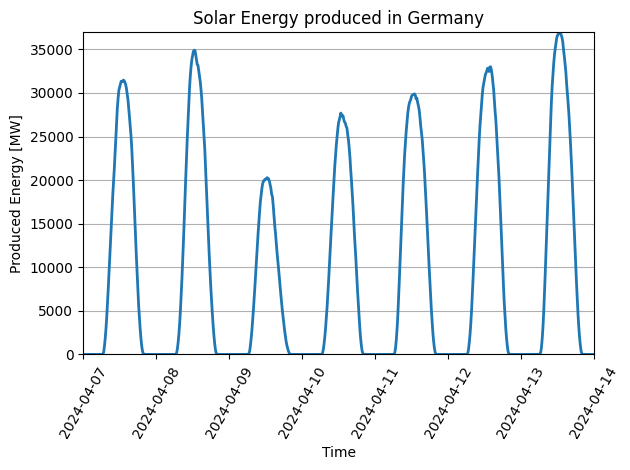

In [46]:
april_2_week = pd.to_datetime('07.04.2024', dayfirst=True)
april_mid = pd.to_datetime('14.04.2024', dayfirst=True)
    
april_df = df[april_2_week:april_mid]
    
def create_normalization_plot(input_df = april_df, normalized_df = None, title = 'Solar Energy produced in Germany', ylabel_2 = 'Normalized Value', share_y_axis = False):
    fig, ax = plt.subplots()
    solar_line = ax.plot(input_df['Solar  - Actual Aggregated [MW]'], label='Solar', linewidth=2)
    ax.set_xlabel('Time')
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
    ax.set_ylabel('Produced Energy [MW]')
    ax.set_title(title)
    ax.set_ylim([0, input_df['Solar  - Actual Aggregated [MW]'].max()])
    ax.set_xlim([input_df.index.min(), input_df.index.max()])
    ax.grid(axis='y')
    
    if normalized_df is not None:
        ax2 = ax.twinx()
        color='tab:red'
        ax2.set_ylabel(ylabel_2, color=color)
        ax2.plot(normalized_df['value'], color=color, linewidth=3, linestyle = '--')
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.set_ylim([normalized_df['value'].min(), normalized_df['value'].max()] if not share_y_axis else [0, input_df['Solar  - Actual Aggregated [MW]'].max()])
        
    fig.tight_layout()
    plt.show()
    
create_normalization_plot()

In [47]:
s_df = spark_session.createDataFrame(april_df['Solar  - Actual Aggregated [MW]'].to_frame(), ['value'])
min_max_norm = NormalizationMinMax(df=s_df, column_names=['value'], in_place=True)
mean_norm = NormalizationMean(df=s_df, column_names=['value'],
                              in_place=True)
z_score_norm = NormalizationZScore(df=s_df, column_names=['value'],
                                   in_place=True)
min_max_df = min_max_norm.filter().toPandas().set_index(april_df.index)
mean_df = mean_norm.filter().toPandas().set_index(april_df.index)
z_score_df = z_score_norm.filter()
denorm = Denormalization(df=z_score_df, normalization_to_revert=z_score_norm)
z_score_df = z_score_df.toPandas().set_index(april_df.index)
denorm_df = denorm.filter().toPandas().set_index(april_df.index)

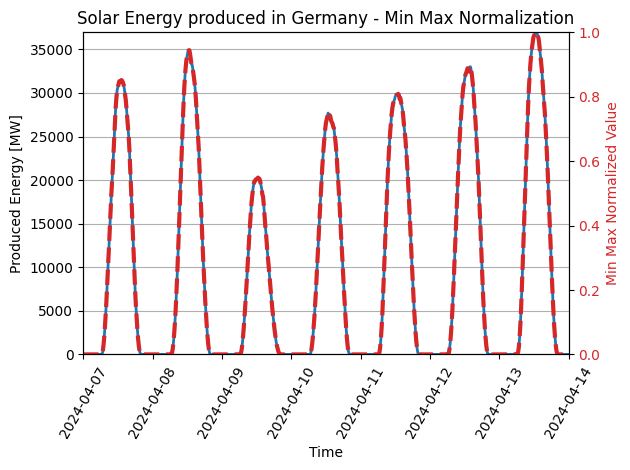

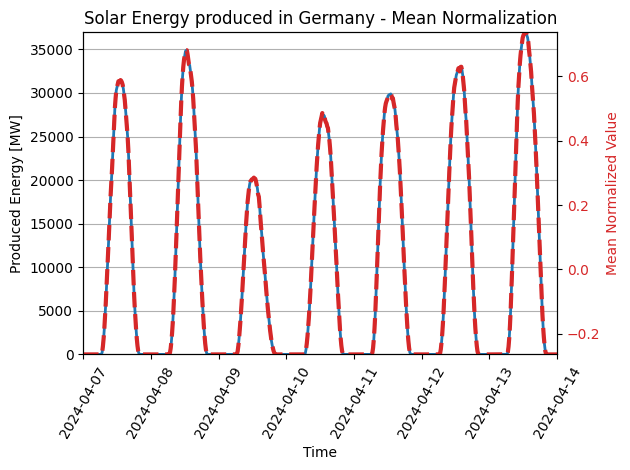

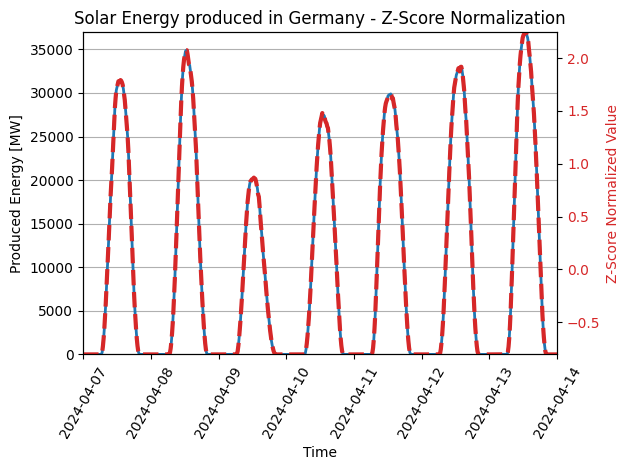

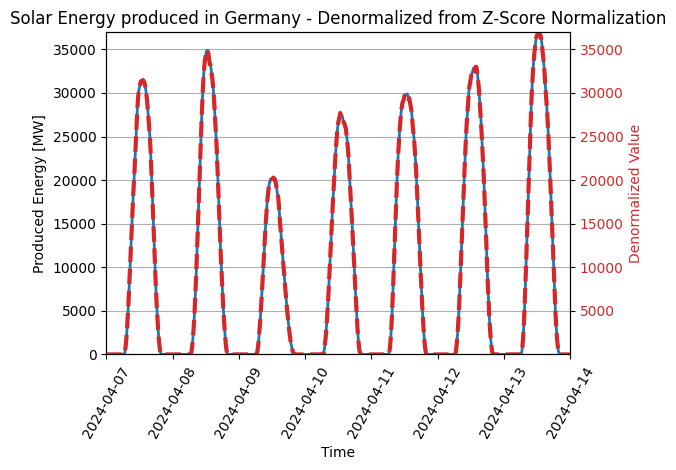

In [48]:
create_normalization_plot(normalized_df=min_max_df, title='Solar Energy produced in Germany - Min Max Normalization', ylabel_2='Min Max Normalized Value')
create_normalization_plot(normalized_df=mean_df, title='Solar Energy produced in Germany - Mean Normalization', ylabel_2='Mean Normalized Value')
create_normalization_plot(normalized_df=z_score_df, title='Solar Energy produced in Germany - Z-Score Normalization', ylabel_2='Z-Score Normalized Value')
create_normalization_plot(normalized_df=denorm_df, title='Solar Energy produced in Germany - Denormalized from Z-Score Normalization', ylabel_2='Denormalized Value')

In [49]:
### Duplicate Detection

In [50]:
dd_df = pd.DataFrame(data={
    'TagName' : ['Temperature_Sensor', 'Temperature_Sensor', 'Temperature_Sensor'],
    'EventTime' : ['2024-01-02 20:03:46.000', '2024-01-02 20:03:46.000', '2024-01-02 20:03:47.000'],
    'Value' : [5.0, 5.0, 7.0]
})
print('Before Duplicate Detection')
print(dd_df.head())

s_dd_df = spark_session.createDataFrame(dd_df, ['TagName', 'EventTime', 'Value'])
output_dd_df = DuplicateDetection(df=s_dd_df).filter().toPandas().sort_values('EventTime')
print('\nAfter Duplicate Detection')
print(output_dd_df.head())



Before Duplicate Detection
              TagName                EventTime  Value
0  Temperature_Sensor  2024-01-02 20:03:46.000    5.0
1  Temperature_Sensor  2024-01-02 20:03:46.000    5.0
2  Temperature_Sensor  2024-01-02 20:03:47.000    7.0

After Duplicate Detection
              TagName                EventTime  Value
1  Temperature_Sensor  2024-01-02 20:03:46.000    5.0
0  Temperature_Sensor  2024-01-02 20:03:47.000    7.0


### Sigma Anomaly Detection

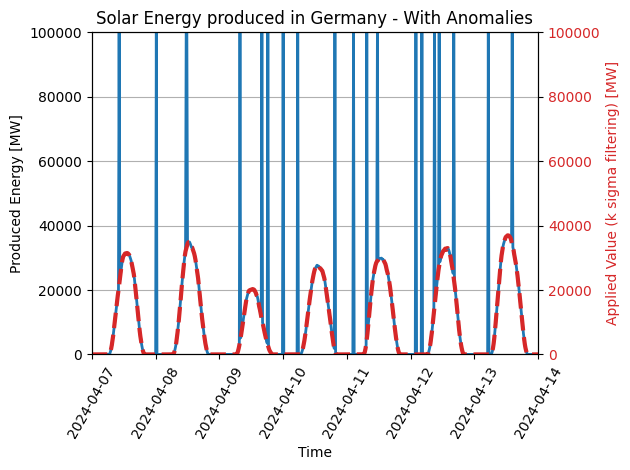

In [51]:
import random

random.seed(0)
sa_april_df = april_df.copy(deep=True)
sa_april_df = sa_april_df['Solar  - Actual Aggregated [MW]'].to_frame()
sa_april_df['EventTime'] = april_df.index
for i in range(0, 20):
    sa_april_df.loc[random.choice(sa_april_df.index.to_list()), 'Solar  - Actual Aggregated [MW]'] = 100000
    
s_dd_df = spark_session.createDataFrame(sa_april_df, ['Solar  - Actual Aggregated [MW]', 'EventTime'])
output_dd_df = KSigmaAnomalyDetection(spark_session, df=s_dd_df, column_names=['Solar  - Actual Aggregated [MW]'], k_value=3.0, use_median=False).filter().toPandas().set_index('EventTime')
output_dd_df['value'] = output_dd_df['Solar  - Actual Aggregated [MW]']
    
create_normalization_plot(input_df=sa_april_df, normalized_df=output_dd_df, title='Solar Energy produced in Germany - With Anomalies', share_y_axis=True, ylabel_2='Applied Value (k sigma filtering) [MW]')


In [52]:
### Interval Filtering

None


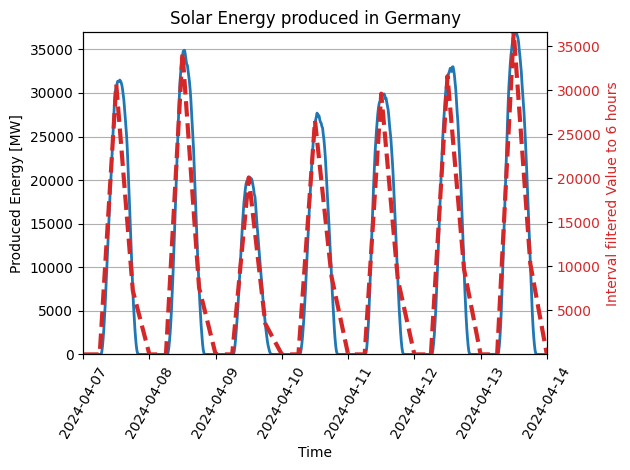

In [53]:
random.seed(0)
intf_april_df = april_df.copy(deep=True)
intf_april_df = intf_april_df['Solar  - Actual Aggregated [MW]'].to_frame()
intf_april_df['EventTime'] = pd.to_datetime(april_df.index)
intf_april_df['EventTime'] = pd.Series(intf_april_df['EventTime'], dtype="string")


intf_ps_df = spark_session.createDataFrame(intf_april_df, ['Solar  - Actual Aggregated [MW]', 'EventTime'])
output_intf_df = IntervalFiltering(spark_session, df=intf_ps_df, interval=6, interval_unit='hours', time_stamp_column_name='EventTime').filter().toPandas()
output_intf_df['value'] = output_intf_df['Solar  - Actual Aggregated [MW]']
output_intf_df['EventTime'] = pd.to_datetime(output_intf_df['EventTime'])
output_intf_df = output_intf_df.set_index('EventTime')

create_normalization_plot(normalized_df=output_intf_df, ylabel_2='Interval filtered Value to 6 hours')